<H2>Download Audio Data from YouTube Video Clip URLs<H2>

In [ ]:
import os
from pytube import YouTube

def download_youtube_audio(url, output_dir='youtube_downloads'):
    '''
    This function is for downloading audio content from youtube video clips.
    These are saved as wav files in the local directory. This code was guided by
    work completed in Ficano. (2023)
    '''
    try:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # using youtube library to instantiate youtube instance
        yt = YouTube(url)

        audio_stream = yt.streams.filter(only_audio=True, 
                                               file_extension='webm').first()

        # save the best quality audio_stream to local storage
        audio_stream.download(output_path=output_dir)

        # this project uses wav file extensions, ensure this is the extension used
        original_file_path = os.path.join(output_dir, audio_stream.default_filename)
        wav_file_path = os.path.join(output_dir, f"{you_tube.title}.wav")
        os.rename(original_file_path, wav_file_path)

    except Exception as e:
        print(f"something went wrong: {e}")


youtube_url = input("YouTube URL to download: ")
download_youtube_audio(youtube_url)

<H2>Word Segmentation<H2>

In [ ]:
import whisperx
from pydub import AudioSegment
import librosa
import numpy as np
import os

'''
This script creates new wav files containing single word utteranes. These words are passed in via a configuration 
object that contains a list of targets words to extract from the full youtube audio clips.
This sript also creates a corresponding text file with the transcription and the start and end times for each word in the file.
The implmentation of this script was guided strongly by the work completed in:
Bain (2023) which includes easy to follow instructions on getting WhisperX up and running
'''


def preprocess_audio(audio_path, desired_sample_rate=16000):

    audio = AudioSegment.from_file(audio_path)

    # resample to match the wav2vec frame rate
    audio = audio.set_frame_rate(desired_sample_rate)
    return audio

def transcribe_and_save_timestamps(audio_path, output_path, model, device, batch_size):
    audio = whisperx.load_audio(audio_path)
    result = model.transcribe(audio, language="en", batch_size=batch_size)

    whisperx_model, metadata = whisperx.load_align_model(language_code=result["language"], 
                                                  device=device)
    aligned_result = whisperx.align(result["segments"], 
                                    whisperx_model, 
                                    metadata, 
                                    audio, 
                                    device=device)

    with open(output_path, 'w') as trans_file:
        for segment in aligned_result["segments"]:
            for words in segment["words"]:
                # in some cases, there is no start and end time, need to handle this through some if statements
                if 'start' in words and 'end' in words and 'score' in words:
                    trans_file.write(f"{words['word']} {words['start']} {words['end']} {words['score']}\n")
                else:
                    trans_file.write(f"{words['word']} - - -\n")  # hitting some missing data e.g. years 2020


def get_top_3_timestamps_from_file(timestamp_file, target_word):
    scores = []

    with open(timestamp_file, 'r') as file:
        for line in file:
            word, start, end, score = line.strip().split()
            if word.lower() == target_word.lower():
                scores.append((float(start), float(end), float(score)))

    # sort the list by probabilty score in descending order and return the top 3
    scores.sort(key=lambda x: x[2], reverse=True)
    return scores[:3]


config = [
    {
        "desired_accent": "Irish English",
        "feature": "words",
        "base_destination_dir": "/home/garrett/Workspace/msc/speech_seg/london/features/words/",
        "words": ["beat", "feet", "seat", "meet", "greet", "heat", "neat", "sweet", "treat", "complete", "bit", "sit",
                             "kit", "lit", "fit", "hit", "tip", "man", "pan", "can", "fan", "car", "ban", "ran", "van", "plan", "hand", "land",
                             "not", "stand", "boat", "coat", "float", "vote", "note", "throat", "wrote", "quote", "gloat", "roam",
                             "but", "book", "word", "hate", "bite", "light", "might", "fight", "night", "right", "sight",
                             "tight", "write", "bright", "height", "delight", "about", "shout", "doubt", "scout", "proud", "loud",
                             "crowd", "mouth", "south", "boot", "shoot", "fruit", "group", "suit", "mute", "root",
                             "thought", "caught", "taught", "bought", "fought", "road", "load", "mode", "remote", "hope", 
                 "rope", "slope", "loaf", "goat", "host", "most", "roast", "toast"]
  
        
    },

    ]



# these are not typical asr settings, had to pass these in to overcome a bug in whisperx
# the model would not let me continue uness temperature setting was passed in 
# please see bug: https://github.com/SYSTRAN/faster-whisper/issues/455
asr_options = {
    "repetition_penalty": 1, 
    "prompt_reset_on_temperature": 0.5,
    "no_repeat_ngram_size": 0
}

device = "cpu"
batch_size = 8
model = whisperx.load_model("small.en", device, compute_type="float32", asr_options=asr_options)

audio_data_dir = "/home/garrett/Workspace/msc/speech_seg/london/audio_data/"
features_dir = "/home/garrett/Workspace/msc/speech_seg/london/features/"
audio_data_cleaned_dir = "/home/garrett/Workspace/msc/speech_seg/london/audio_data_cleaned/"

# transcribe audio file just once and save timestamps, if transcribed file already exists, use it
for filename in os.listdir(audio_data_dir):
    if filename.endswith('.wav'):
        audio_path = os.path.join(audio_data_dir, filename)
        destination_wav_path = os.path.join(audio_data_cleaned_dir, filename)
        timestamp_file = os.path.join(audio_data_cleaned_dir, f"{filename}.txt")
        
        if not os.path.exists(timestamp_file):
            print(f"Transcribing AUDIO: {audio_path}")
            audio = preprocess_audio(audio_path)
            audio.export(destination_wav_path, format='wav')
            transcribe_and_save_timestamps(destination_wav_path, timestamp_file, model, device, batch_size)
        else:
            print(f"Timestamps already exist for {filename}, skipping transcription.")
            
            

# iterate over the features
for feature_config in config:
    feature = feature_config["feature"]
    words = feature_config["words"]

    for filename in os.listdir(audio_data_dir):
        if filename.endswith('.wav'):
            print(f"processing {feature} for audiofile: {filename}")
            timestamp_file = os.path.join(audio_data_cleaned_dir, f"{filename}.txt")

            for word in words:
                top_timestamps = get_top_3_timestamps_from_file(timestamp_file, word)
                for index, (start_sec, end_sec, score) in enumerate(top_timestamps):
                    start_ms = int(start_sec * 1000)
                    end_ms = int(end_sec * 1000)
                    
                    audio = AudioSegment.from_file(os.path.join(audio_data_cleaned_dir, filename))
                    word_audio = audio[start_ms:end_ms]

                    save_dir = os.path.join(features_dir, feature, word)
                    os.makedirs(save_dir, exist_ok=True)

                    file_name_without_extension = filename[:-4]
                    file_dir = os.path.join(save_dir, file_name_without_extension)
                    os.makedirs(file_dir, exist_ok=True)  

                    save_path = os.path.join(file_dir, f"{word}_{index + 1}.wav") #index to filename
                    word_audio.export(save_path, format='wav')

<H2>Phoneme Segmentation<H2>

In [ ]:
import os
from pydub import AudioSegment
import numpy as np
import librosa
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import eng_to_ipa as ipa
import time
import scipy.io.wavfile
import shutil

'''
This script creates a new wav file for every phoneme detected in the word files. 
It iterates over the word files that exists in a given base directory (provided via the cofig var).
For each word, extract the phonemes using the Wav2Vec model and save these phonemes as a new wav file.
The work completed in this script was guided by the work seen in :
Xu (2021) and code samples provided in Baevski (2021).
'''


# when rerunning this script, some of residual files were causing issues
# this funciton is used to clean up files for a fresh execution
def clear_directory(directory):

    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f'error deleting {file_path} : {e}')

def save_phonemes_as_audio(audio, phoneme_list, output_dir, sr):

    audio_segment_data = None
    audio_int16 = None
    start_time_ms= None
    end_time_ms = None
    start_sample = None
    end_sample = None
    
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    


    for item in phoneme_list:
        phoneme = item['phoneme']
        if phoneme.strip() == '':
            continue

        try:
            start_ms = int(float(item['start_time']))
            end_ms = int(float(item['end_time']))
        except Exception as e:
            print("error casting start and end times: " + str(e))
        
        start_sample = int(start_ms * sr / 1000)
        end_sample = int(end_ms * sr / 1000)

        
        try:
            audio_segment_data = audio[start_sample:end_sample]
        except Exception as e:
            print(f"error creating audio segnment data:  {e}")
            
        # adding 2 second buffer at start and end of audio, this seems to 
        # help in the performance of word and phoneme segmentation
        silence_duration = 2  # seconds
        silence_samples = int(silence_duration * sr)
        silence = np.zeros(silence_samples)
        audio_segment_data_silenced = np.concatenate((silence, audio_segment_data, silence))
        

        filename = os.path.join(output_dir, f"{phoneme}_{start_ms:.2f}_{end_ms:.2f}.wav")
        try:
            scipy.io.wavfile.write(filename, sr, audio_segment_data_silenced)
        except Exception as e:
            print(f"Error exporting audio for phoneme '{phoneme}': {e}")



def process_audio(file_path, word, model, processor, phoneme_directory, chunk_duration=1.0):
    try:
        print(f"Processing file: {file_path}")
        audio = None
        input_values = None
        predicted_ids = None
        transcription = None
        
        audio, orig_sampling_rate = librosa.load(file_path, sr=16000)

        
        audio_silenced = None
        silence_duration = 2
        silence_samples = int(silence_duration * orig_sampling_rate)
        silence = np.zeros(silence_samples)
        audio_silenced = np.concatenate((silence, audio, silence))
        
        total_duration_seconds = len(audio) / orig_sampling_rate

        input_values = processor(audio_silenced, sampling_rate=16000, return_tensors="pt").input_values
        

        with torch.no_grad():
            logits = model(input_values).logits

        probabilities = torch.nn.functional.softmax(logits, dim=-1)

        predicted_ids = torch.argmax(probabilities, dim=-1)
        confidence_scores = probabilities.max(dim=-1).values
        
        transcription = processor.batch_decode(predicted_ids)[0]
        
        print(transcription)
        
        duration_per_token = total_duration_seconds * 1000 / len(transcription)  # milliseconds
        
        phoneme_list = []
        phoneme_confidences = []
        for i, phoneme in enumerate(transcription):
            start_time = i * duration_per_token
            end_time = (i + 1) * duration_per_token
            phoneme_confidence = confidence_scores[0, i].item()  # confidence scor for each phoneme
            phoneme_confidences.append(phoneme_confidence)
            phoneme_list.append({
                'phoneme': phoneme,
                'start_time': f"{start_time:.2f}",
                'end_time': f"{end_time:.2f}",
                'probability': phoneme_confidence
            })
        
        for phoneme in phoneme_list:
            print(f"Phoneme: {phoneme['phoneme']}, Probability: {phoneme['probability']:.4f}")

        
        output_dir = os.path.join(os.path.dirname(file_path), phoneme_directory)
        print(output_dir)
        # clear output directory before processing to avoid duplicates
        if os.path.exists(output_dir):
            clear_directory(output_dir)
            
        save_phonemes_as_audio(audio, phoneme_list, output_dir, orig_sampling_rate)

    except Exception as e:
        print(f"Error processing audio: {e}")
        
    finally:
        pass

def main():

    
    config = [
    {
        "desired_accent": "Irish English",
        "feature": "words",
        "base_destination_dir": "/home/garrett/Workspace/msc/speech_seg/london/features/words/",
        "words": ["beat", "feet", "seat", "meet", "greet", "heat", "neat", "sweet", "treat", "complete", "bit", "sit",
                             "kit", "lit", "fit", "hit", "tip", "man", "pan", "can", "fan", "car", "ban", "ran", "van", "plan", "hand", "land",
                             "not", "stand", "boat", "coat", "float", "vote", "note", "throat", "wrote", "quote", "gloat", "roam",
                             "but", "book", "word", "hate", "bite", "light", "might", "fight", "night", "right", "sight",
                             "tight", "write", "bright", "height", "delight", "about", "shout", "doubt", "scout", "proud", "loud",
                             "crowd", "mouth", "south", "boot", "shoot", "fruit", "group", "suit", "mute", "root",
                             "thought", "caught", "taught", "bought", "fought", "road", "load", "mode", "remote", "hope", 
                 "rope", "slope", "loaf", "goat", "host", "most", "roast", "toast"]
  
        
    },

    ]

    try:
        # this is the hugging face model used for phonenem seg
        model_name = "facebook/wav2vec2-lv-60-espeak-cv-ft"
        model = Wav2Vec2ForCTC.from_pretrained(model_name)
        processor = Wav2Vec2Processor.from_pretrained(model_name)
    except Exception as e:
        print(f"error creating model: {e}")
        
        
        
    try:
        # iterae of the word wav files in each base directory and extract the relevant phonemes
        # from these word files. Each phoneme is saved as a new wav file 
        for accent_config in config:
            base_dir = accent_config["base_destination_dir"]
            
            for word in accent_config["words"]:
                word_dir = os.path.join(base_dir, word)
                if os.path.exists(word_dir):
                    individual_dirs = [d for d in os.listdir(word_dir) if os.path.isdir(os.path.join(word_dir, d))]
                    for individual_dir in individual_dirs:
                        individual_dir_path = os.path.join(word_dir, individual_dir)
                        word_files = [f for f in os.listdir(individual_dir_path) if f.endswith(".wav")]
                        for word_file in word_files:
                            file_path = os.path.join(individual_dir_path, word_file)
                            phoneme_directory = "phonemes_" + str(word_file[:-4])
                            if os.path.exists(file_path):
                                process_audio(file_path, word, model, processor, phoneme_directory)
                                time.sleep(3)
            
            
            
                            
    except Exception as e:
        print(f"error getting words for processing: {e}")

if __name__ == "__main__":
    main()
        
        
        

    


<H2>Pitch Analysis<H2>

/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=882
  return f(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1147
  return f(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=750
  return f(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=530
  return f(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1059
  return f(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=618
  return f(*args, **kwar

Dublin descriptive stats for 'a':
count     147.000000
mean      633.437683
std       411.180176
min       152.481049
25%       276.597519
50%       629.679138
75%       777.253418
max      2594.207520
Name: Dublin, dtype: float64
 
London descriptive stats for 'a':
count     176.000000
mean      568.901917
std       310.481567
min       146.906540
25%       296.860611
50%       597.500549
75%       748.143555
max      1622.890625
Name: London, dtype: float64
 
Liverpool descriptive stats for 'a':
count     135.000000
mean      531.495056
std       303.889557
min       151.410309
25%       228.123688
50%       523.468262
75%       734.734924
max      1430.169434
Name: Liverpool, dtype: float64
 


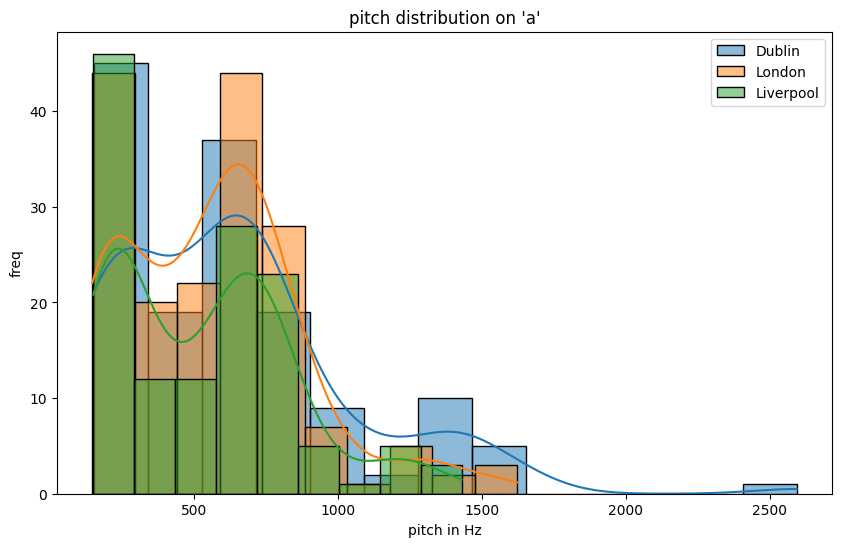

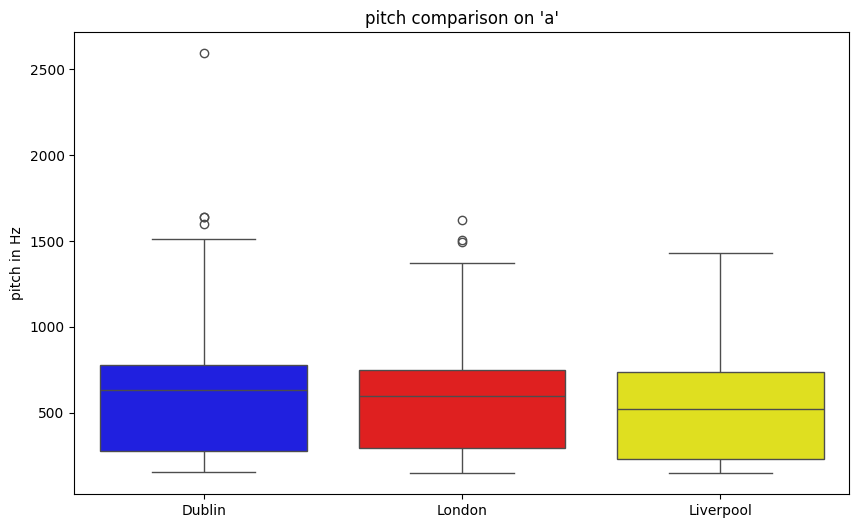

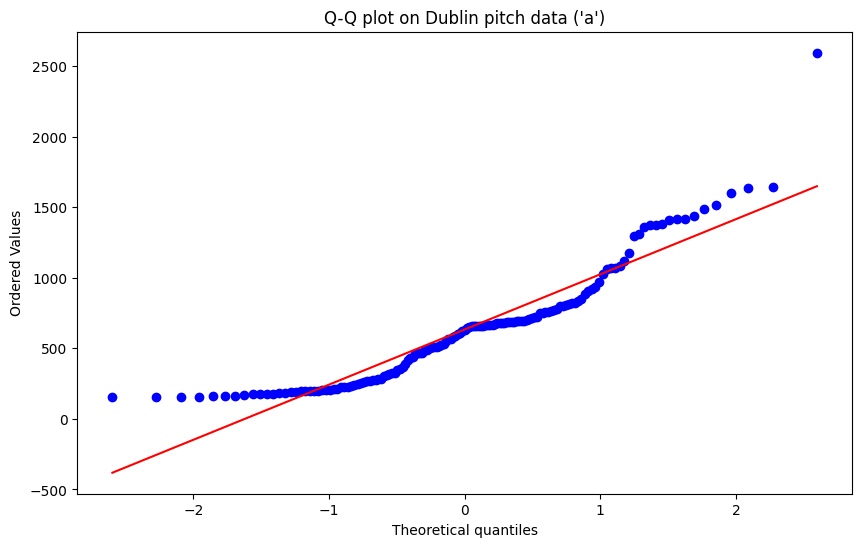

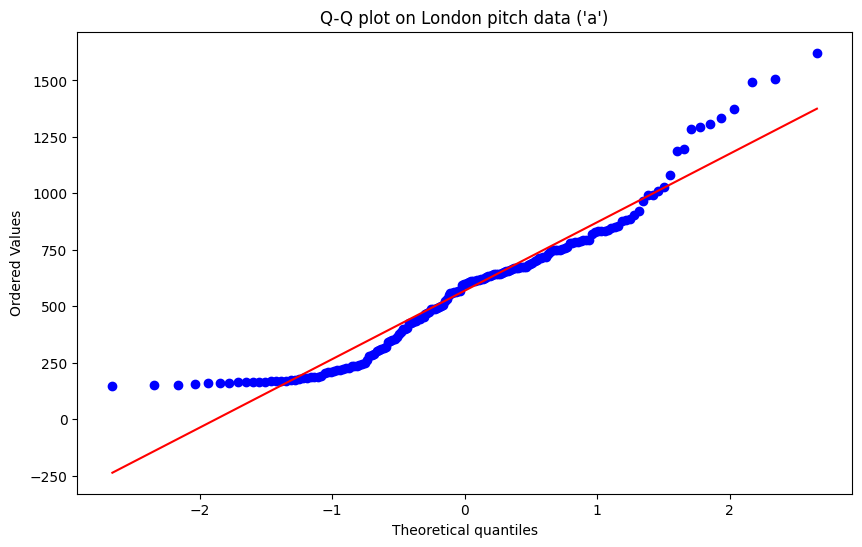

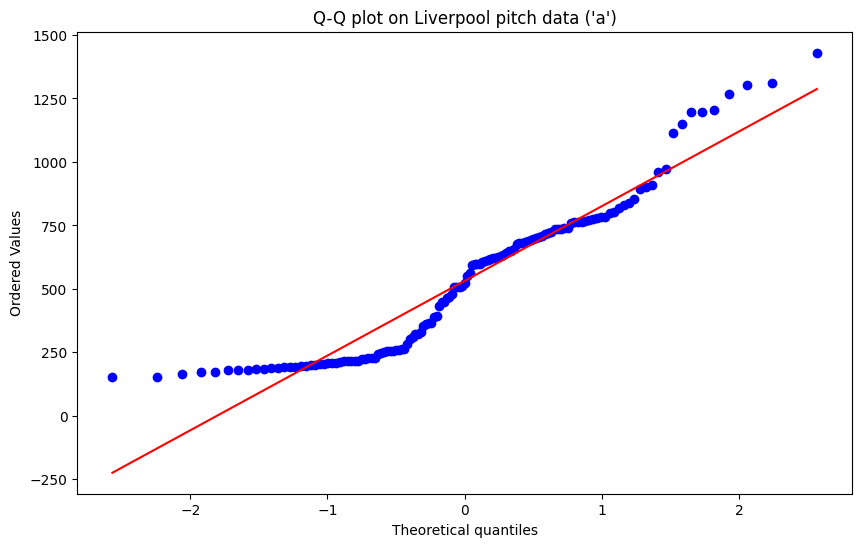

 
shapiro-wilk test for normality
Dublin: p-value = 2.9012516833404334e-09
London: p-value = 3.256991192301939e-07
Liverpool: p-value = 2.3140519544995186e-07
 
 
levene's test for homogeneity of variance
p-value = 0.02995686625221508
 
mann whitney U test between Dublin and London for utterance 'a': U=13776.0, Original p-value=0.3151667810204376, Permutation p-value=0.1547
mann whitney U test between Dublin and Liverpool for utterance 'a': U=10997.0, Original p-value=0.11643489079958502, Permutation p-value=0.0589
mann whitney U test between London and Liverpool for utterance 'a': U=12495.0, Original p-value=0.4343148431545316, Permutation p-value=0.2195


/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=441
  return f(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1764
  return f(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=794
  return f(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=530
  return f(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=706
  return f(*args, **kwar

Dublin descriptive stats for 'i':
count     38.000000
mean     389.655853
std       98.102844
min      211.236618
25%      318.819321
50%      403.014603
75%      447.512352
max      656.721313
Name: Dublin, dtype: float64
 
London descriptive stats for 'i':
count     91.000000
mean     399.662994
std      119.737839
min      152.416321
25%      350.484329
50%      402.186035
75%      483.940826
max      636.895996
Name: London, dtype: float64
 
Liverpool descriptive stats for 'i':
count     26.000000
mean     356.060516
std      109.290329
min      158.451736
25%      269.688766
50%      380.601105
75%      441.769066
max      514.526855
Name: Liverpool, dtype: float64
 


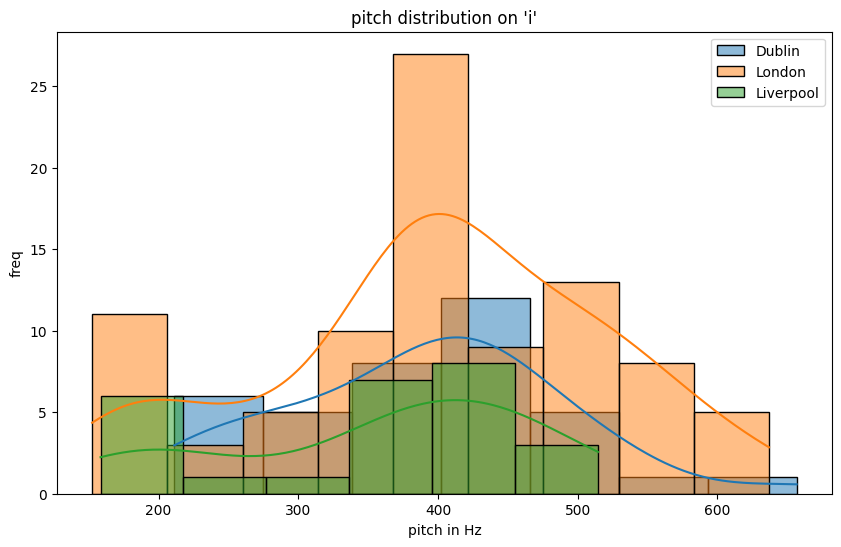

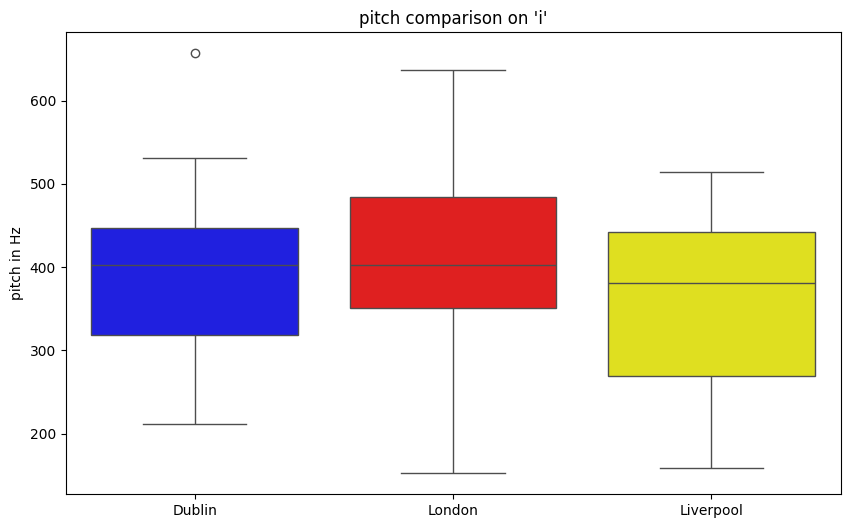

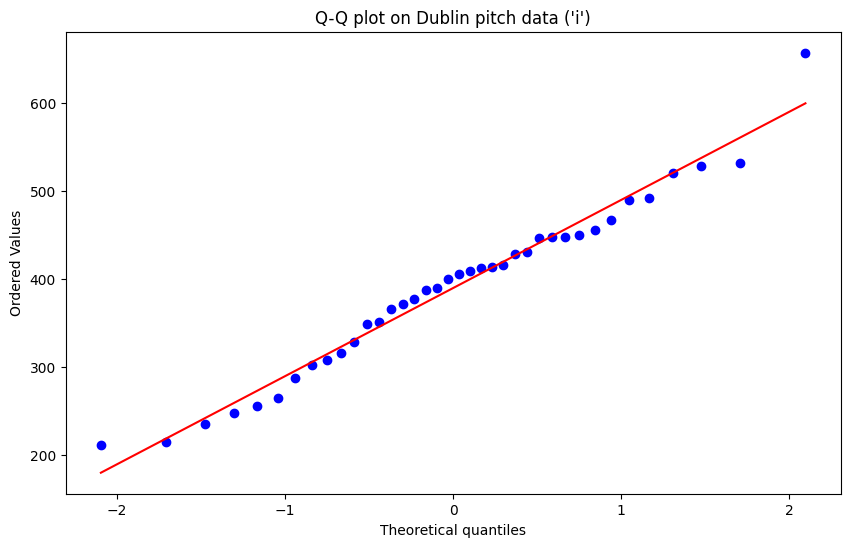

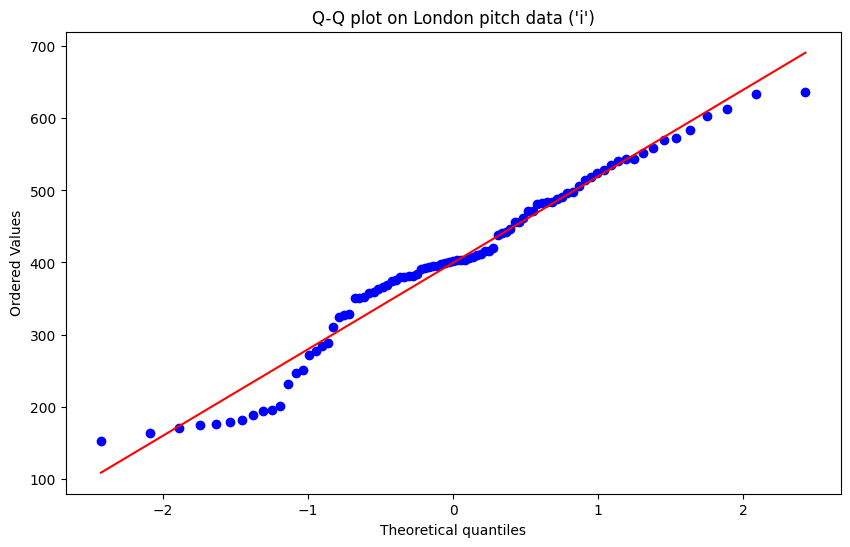

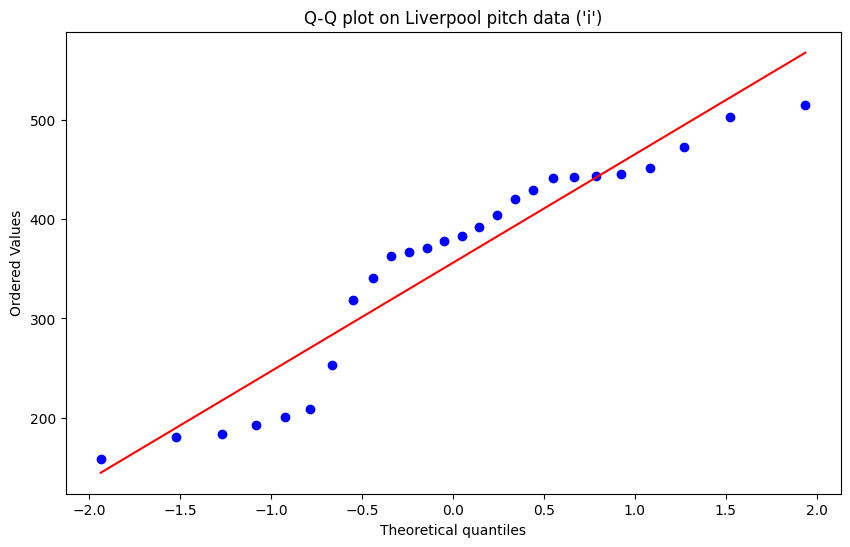

 
shapiro-wilk test for normality
Dublin: p-value = 0.5772241353988647
London: p-value = 0.019021999090909958
Liverpool: p-value = 0.015153867192566395
 
 
levene's test for homogeneity of variance
p-value = 0.5172060964283371
 
mann whitney U test between Dublin and London for utterance 'i': U=1621.0, Original p-value=0.5786131856366257, Permutation p-value=0.7103
mann whitney U test between Dublin and Liverpool for utterance 'i': U=569.0, Original p-value=0.30849530489116006, Permutation p-value=0.1539
mann whitney U test between London and Liverpool for utterance 'i': U=1409.0, Original p-value=0.13930362155805742, Permutation p-value=0.0717


/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1235
  return f(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1191
  return f(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=530
  return f(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=618
  return f(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=441
  return f(*args, **kwa

Dublin descriptive stats for 'o':
count      80.000000
mean      573.937744
std       242.702835
min       159.108063
25%       407.958794
50%       588.952301
75%       671.375198
max      1303.026367
Name: Dublin, dtype: float64
 
London descriptive stats for 'o':
count    154.000000
mean     432.115570
std      142.225037
min      146.387268
25%      360.161934
50%      444.145004
75%      509.697289
max      906.874817
Name: London, dtype: float64
 
Liverpool descriptive stats for 'o':
count     89.000000
mean     405.093384
std      143.179276
min      148.169098
25%      308.808380
50%      433.087128
75%      492.199066
max      915.824097
Name: Liverpool, dtype: float64
 


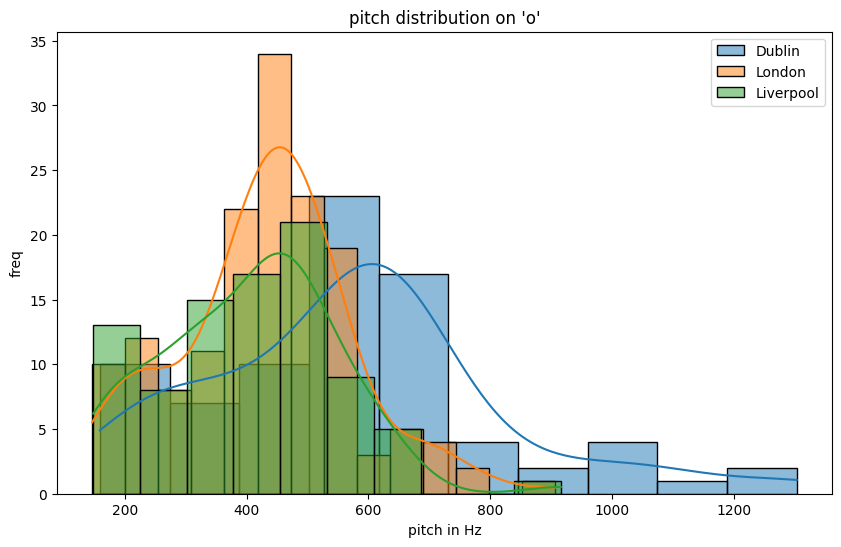

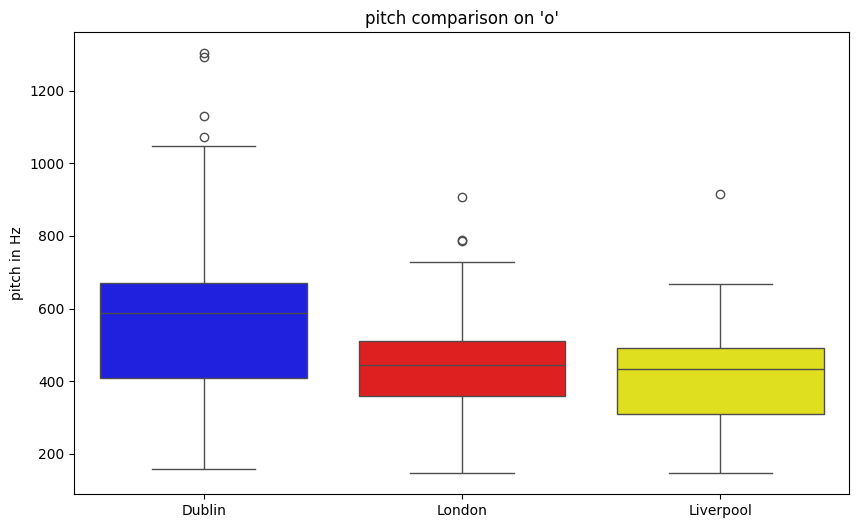

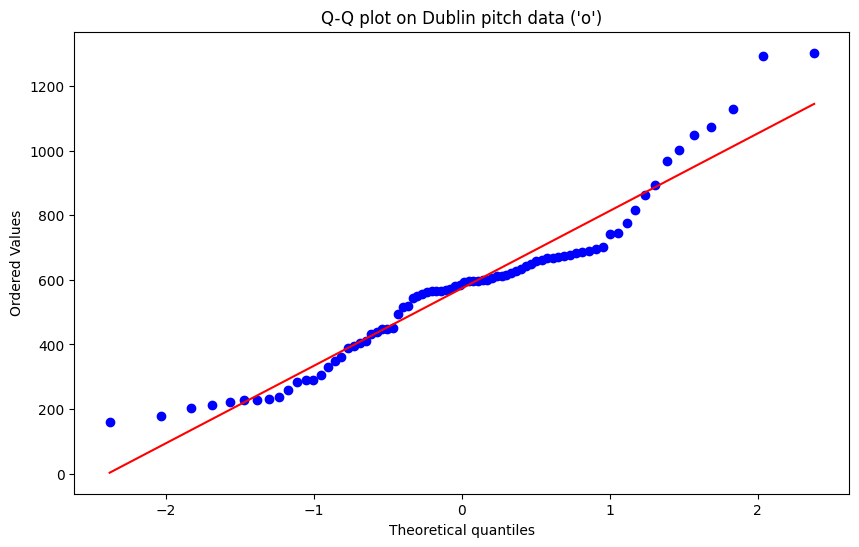

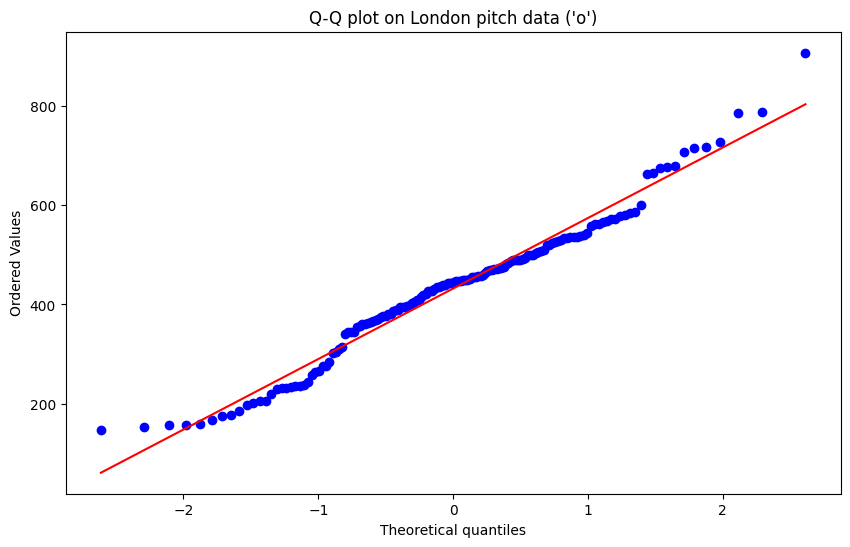

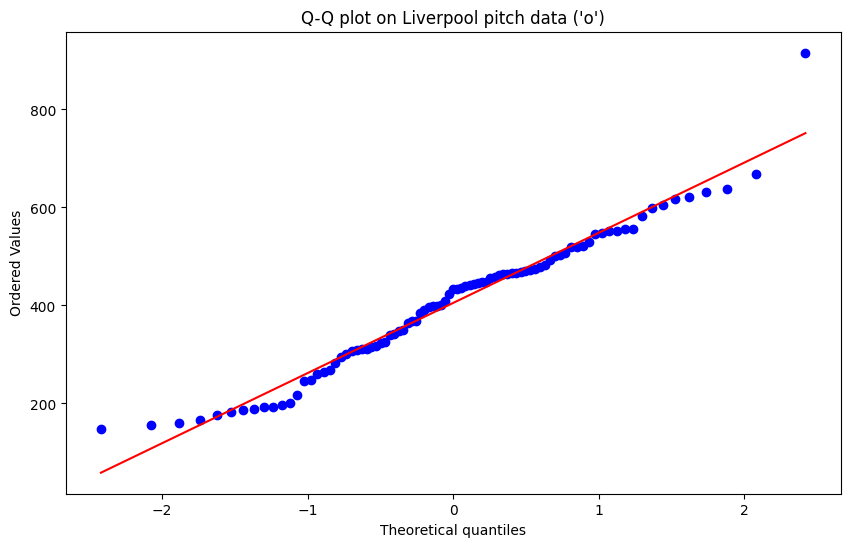

 
shapiro-wilk test for normality
Dublin: p-value = 0.0009801102569326758
London: p-value = 0.006736109033226967
Liverpool: p-value = 0.030251190066337585
 
 
levene's test for homogeneity of variance
p-value = 6.810700577474713e-05
 
mann whitney U test between Dublin and London for utterance 'o': U=8641.0, Original p-value=4.418318158790521e-07, Permutation p-value=0.0
mann whitney U test between Dublin and Liverpool for utterance 'o': U=5226.0, Original p-value=1.570486784613197e-07, Permutation p-value=0.0
mann whitney U test between London and Liverpool for utterance 'o': U=7556.0, Original p-value=0.18328116920767723, Permutation p-value=0.0921


/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=794
  return f(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=618
  return f(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=552
  return f(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1037
  return f(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=728
  return f(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=397
  return f(*args, **kwarg

Dublin descriptive stats for 'u':
count     40.000000
mean     281.776520
std       71.565910
min      146.906799
25%      222.450897
50%      299.260818
75%      326.312233
max      413.344971
Name: Dublin, dtype: float64
 
London descriptive stats for 'u':
count     28.000000
mean     293.604309
std       70.926613
min      153.046600
25%      231.961128
50%      318.113525
75%      334.184509
max      481.041656
Name: London, dtype: float64
 
Liverpool descriptive stats for 'u':
count     44.000000
mean     255.362564
std       58.302166
min      149.818451
25%      214.996304
50%      244.925125
75%      299.638786
max      398.764862
Name: Liverpool, dtype: float64
 


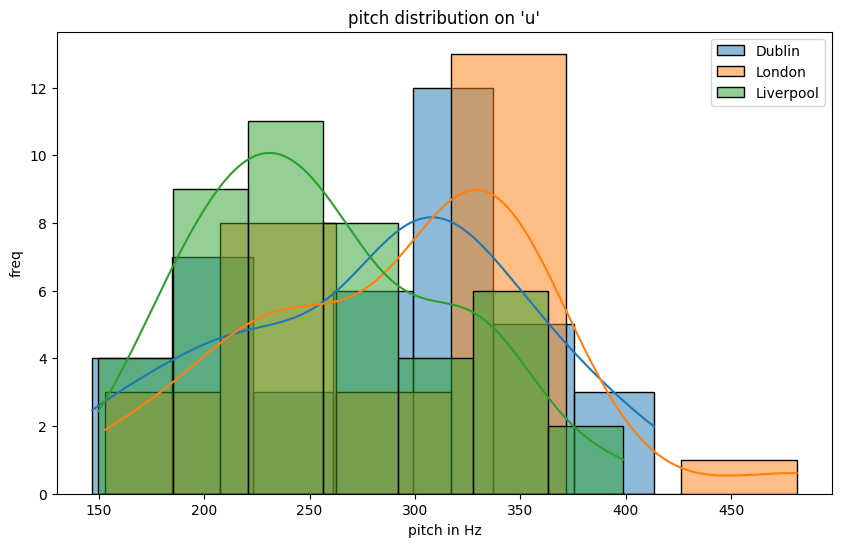

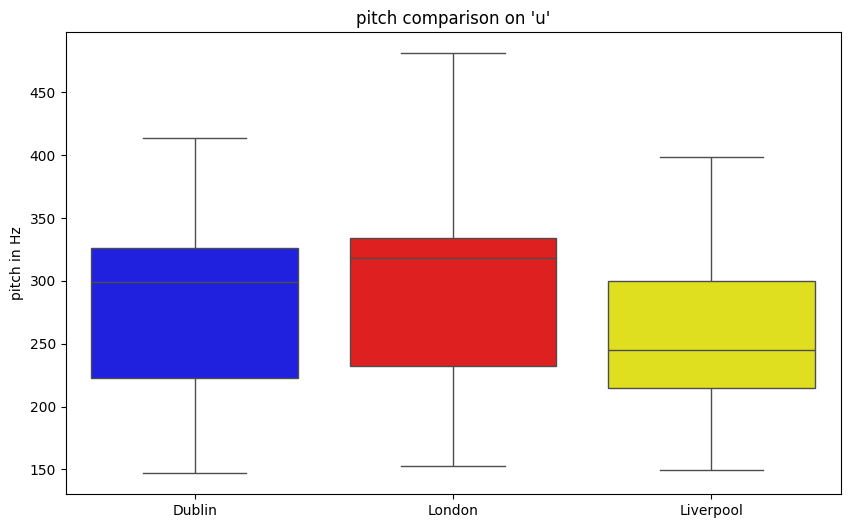

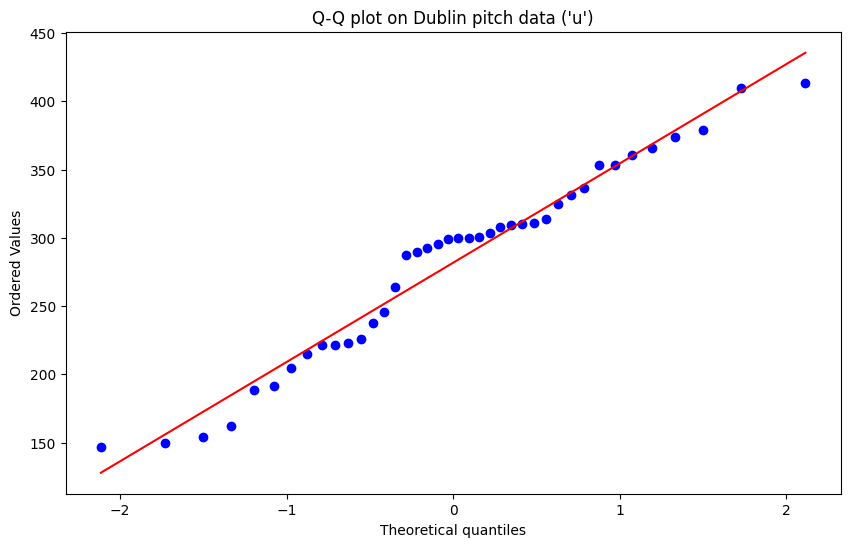

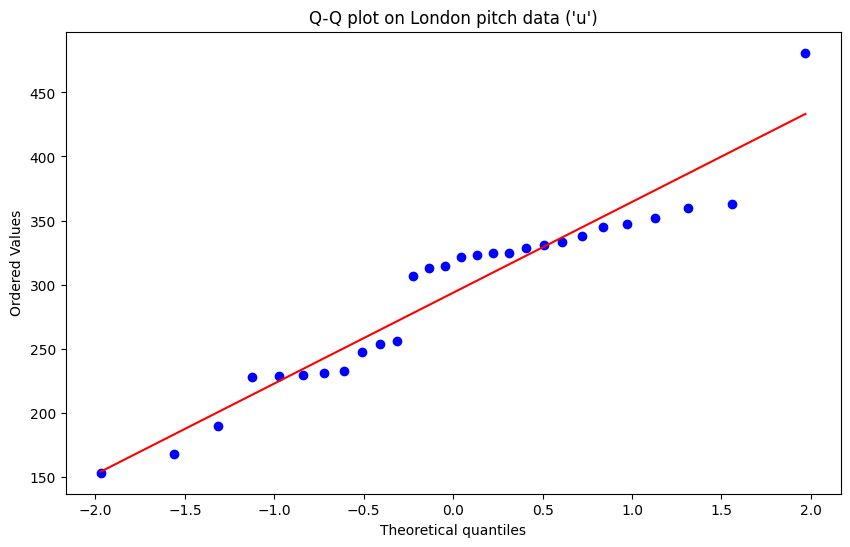

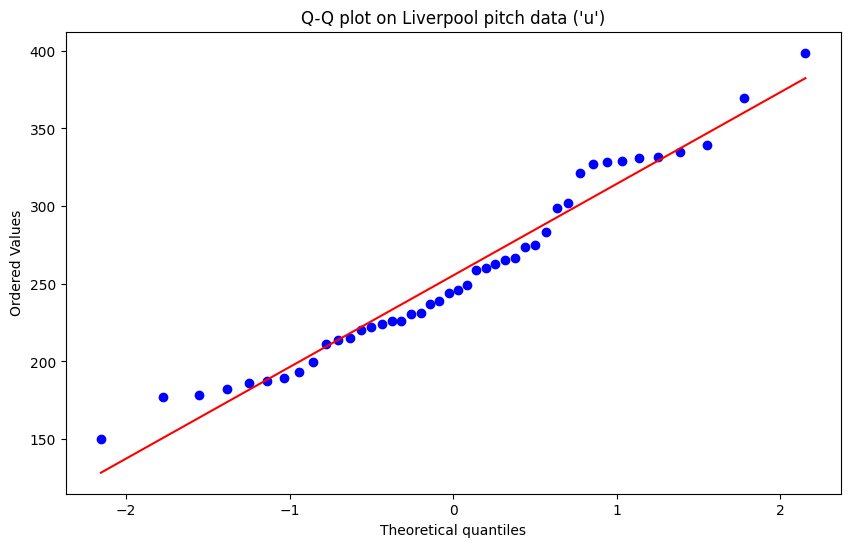

 
shapiro-wilk test for normality
Dublin: p-value = 0.1716075837612152
London: p-value = 0.06292778253555298
Liverpool: p-value = 0.15768925845623016
 
 
levene's test for homogeneity of variance
p-value = 0.6072822423852942
 
mann whitney U test between Dublin and London for utterance 'u': U=482.0, Original p-value=0.3341759134855803, Permutation p-value=0.8316
mann whitney U test between Dublin and Liverpool for utterance 'u': U=1080.0, Original p-value=0.07397528581475085, Permutation p-value=0.0358
mann whitney U test between London and Liverpool for utterance 'u': U=820.0, Original p-value=0.018740575289043805, Permutation p-value=0.009


In [18]:
import librosa
import numpy as np
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import mannwhitneyu

def calc_mean_pitch(y, sr):
    '''
    get the mean pitch for an audio file containg utterance
    Used the following documentaiton for guidance: 
    pavlos163 (2017)
    '''
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch = []
    for t in range(pitches.shape[1]):
        index = magnitudes[:, t].argmax()
        pitch.append(pitches[index, t])

    pitch = np.array(pitch)
    #print(pitch)
    pitch = pitch[pitch > 0]
    mean_pitch = np.mean(pitch)
    return mean_pitch

def get_pitch(directory):
    mean_pitch_vals = []
    # iterate over the file directory and get the mean pitch values
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            y, sr = librosa.load(os.path.join(directory, filename))
            # cut the 2 seconds from start and end that was added earlier
            y_trimmed = y[2*sr:-2*sr] 
            pitch = calc_mean_pitch(y_trimmed, sr)
            mean_pitch_vals.append((filename, pitch))

    return mean_pitch_vals
    
    
def perform_mann_whitney_and_permutation_test(data_1, data_2, perm_count=10000):
    '''
    perform mann whintey permutation testing , this code was guided by (same as pitch):
    
    Cicek (2022)
    and
    Deak (2022)
    
    this function assumes the data is balanced for the 2 accent data sets.
    '''
    original_stat, original_p_value = stats.mannwhitneyu(data_1, data_2, alternative='two-sided')

    combined_data = np.concatenate([data_1, data_2])
    n = len(data_1)

    perm_stats = np.zeros(perm_count)
    for i in range(perm_count):
        np.random.shuffle(combined_data)
        perm_stat, _ = stats.mannwhitneyu(combined_data[:n], combined_data[n:], alternative='two-sided')
        perm_stats[i] = perm_stat

    p_value_perm = np.mean(perm_stats >= original_stat)

    return original_stat, original_p_value, p_value_perm
    

utterances = ['a', 'i', 'o', 'u']

base_directories = {
    'Dublin': '/home/garrett/Workspace/msc/speech_seg/dublin/features/Monophthongs/',
    'London': '/home/garrett/Workspace/msc/speech_seg/london/features/Monophthongs/',
    'Liverpool': '/home/garrett/Workspace/msc/speech_seg/liverpool/features/Monophthongs/'
}

for utterance in utterances:
    pitch_values = {}
    min_count = float('inf')

    for accent, base_dir in base_directories.items():
        directory = os.path.join(base_dir, utterance)
        pitches = get_pitch(directory)
        pitch_values[accent] = pd.Series([pitch for _, pitch in pitches], name=accent)
        min_count = min(min_count, len(pitch_values[accent]))

        
    for accent in pitch_values:
        pitch_values[accent] = pitch_values[accent].dropna()
        print(f"{accent} descriptive stats for '{utterance}':")
        print(pitch_values[accent].describe())
        print(" ")
    
    plt.figure(figsize=(10, 6))
    for accent, values in pitch_values.items():
        sns.histplot(values, label=accent, kde=True)
    plt.title(f"pitch distribution on '{utterance}'")
    plt.xlabel("pitch in Hz")
    plt.ylabel("freq")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=list(pitch_values.values()), palette=["blue", "red", "yellow"])
    plt.xticks(range(len(pitch_values)), pitch_values.keys())
    plt.title(f"pitch comparison on '{utterance}'")
    plt.ylabel("pitch in Hz")
    plt.show()

    for accent, values in pitch_values.items():
        plt.figure(figsize=(10, 6))
        stats.probplot(values, dist="norm", plot=plt)
        plt.title(f"Q-Q plot on {accent} pitch data ('{utterance}')")
        plt.show()

    # shapiro-wilk normality testing
    print(" ")
    print("shapiro-wilk test for normality")
    for accent in pitch_values:
        _, p_value_normality = stats.shapiro(pitch_values[accent])
        print(f"{accent}: p-value = {p_value_normality}")
    print(" ")

    # levene's variance testing
    _, p_value_levene = stats.levene(*pitch_values.values())
    print(" ")
    print("levene's test for homogeneity of variance")
    print(f"p-value = {p_value_levene}")
    print(" ")

    accents = list(pitch_values.keys())
    for i in range(len(accents)):
        for x in range(i + 1, len(accents)):
            perform_mann_whitney_and_permutation_test(pitch_values[accents[i]], pitch_values[accents[x]])
            
            original_stat, original_p_value, p_value_perm = perform_mann_whitney_and_permutation_test(pitch_values[accents[i]], pitch_values[accents[x]])
            print(f"mann whitney U test between {accents[i]} and {accents[x]} for utterance '{utterance}': U={original_stat}, Original p-value={original_p_value}, Permutation p-value={p_value_perm}")


<H2>Duration analysis<H2>

/tmp/ipykernel_8055/4063332291.py:17: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(audio, sr=sr) - 4
/tmp/ipykernel_8055/4063332291.py:17: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(audio, sr=sr) - 4
/tmp/ipykernel_8055/4063332291.py:17: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(audio, sr=sr) - 4
/tmp/ipykernel_8055/4063332291.py:17: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(audio, sr=sr) - 4
/tmp/ipykernel_8055/4063332291.py:17: FutureWarning: Pass y=[0. 0. 0

a_54_1.wav 0.040000000000000036
a_31_1.wav 0.040000000000000036
a_45_2.wav 0.0519999999999996
a_23_4.wav 0.040000000000000036
a_10_2.wav 0.03399999999999981
a_26_7.wav 0.02400000000000002
a_37_1.wav 0.0519999999999996
a_19_1.wav 0.03399999999999981
a_46_3.wav 0.03399999999999981
a_19.wav 0.03399999999999981
a_30_8.wav 0.04800000000000004
a_51_6.wav 0.02799999999999958
a_9.wav 0.052999999999999936
a_58_3.wav 0.03599999999999959
a_19_6.wav 0.03200000000000003
a_17_1.wav 0.04800000000000004
a_11_5.wav 0.03200000000000003
a_31_9.wav 0.03200000000000003
a_58_2.wav 0.02400000000000002
a_14.wav 0.03599999999999959
a_46_2.wav 0.043999999999999595
a_23_1.wav 0.03200000000000003
a_52_5.wav 0.04499999999999993
a_23.wav 0.03599999999999959
a_45_5.wav 0.05999999999999961
a_37_6.wav 0.0259999999999998
a_42_1.wav 0.05999999999999961
a_37_5.wav 0.03399999999999981
a_31_8.wav 0.03599999999999959
a_51_1.wav 0.03599999999999959
a_32.wav 0.0519999999999996
a_23_8.wav 0.0519999999999996
a_34_3.wav 0.048000

o_34.wav 0.02799999999999958
o_27.wav 0.08699999999999974
o_50.wav 0.052999999999999936
o_7.wav 0.03200000000000003
o_10_1.wav 0.03500000000000014
o_9_2.wav 0.07399999999999984
o_19_4.wav 0.03599999999999959
o_1.wav 0.019999999999999574
o_22_1.wav 0.05400000000000027
o_12_4.wav 0.04699999999999971
o_23_4.wav 0.06400000000000006
o_8.wav 0.06700000000000017
o_19_3.wav 0.05400000000000027
o_50_1.wav 0.04600000000000026
o_24_1.wav 0.043999999999999595
o_42.wav 0.05999999999999961
o_1_1.wav 0.040000000000000036
o_15_3.wav 0.03599999999999959
o_19_2.wav 0.03599999999999959
o_9_3.wav 0.06299999999999972
o_6.wav 0.05999999999999961
o_23.wav 0.02799999999999958
o_3.wav 0.1200000000000001
o_129_2.wav 0.040000000000000036
o_132_3.wav 0.07200000000000006
o_131_1.wav 0.040000000000000036
o_135.wav 0.027000000000000135
o_136_3.wav 0.13999999999999968
o_128_1.wav 0.027000000000000135
o_104_1.wav 0.040000000000000036
o_111_6.wav 0.06700000000000017
o_124.wav 0.03399999999999981
o_133_4.wav 0.059999999

/tmp/ipykernel_8055/4063332291.py:17: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(audio, sr=sr) - 4
/tmp/ipykernel_8055/4063332291.py:17: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(audio, sr=sr) - 4
/tmp/ipykernel_8055/4063332291.py:17: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(audio, sr=sr) - 4
/tmp/ipykernel_8055/4063332291.py:17: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(audio, sr=sr) - 4
/tmp/ipykernel_8055/4063332291.py:17: FutureWarning: Pass y=[0. 0. 0

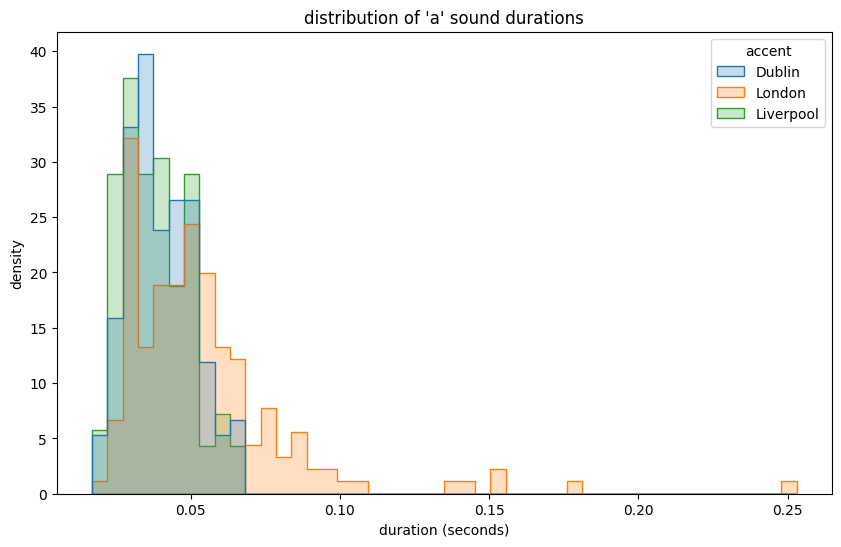

/tmp/ipykernel_8055/4063332291.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=current_utterance_data, x='accent', y='duration', palette=["blue", "red", "yellow"])


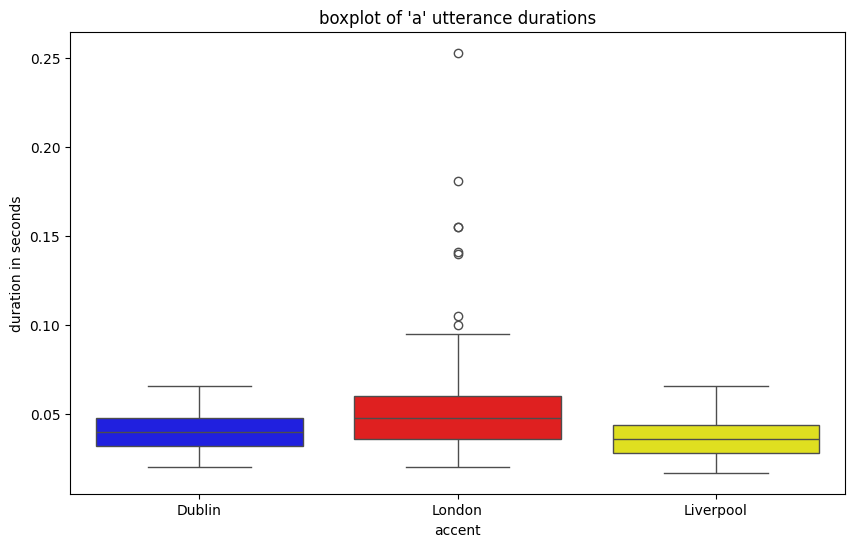

mann whitney U test between Dublin and London for utterance 'a': U=8385.0, Original p-value=4.8736360794271354e-08, Permutation p-value=1.0
mann whitney U test between Dublin and Liverpool for utterance 'a': U=11107.0, Original p-value=0.08239352112071455, Permutation p-value=0.0443
mann whitney U test between London and Liverpool for utterance 'a': U=17087.0, Original p-value=3.1594168124195385e-11, Permutation p-value=0.0


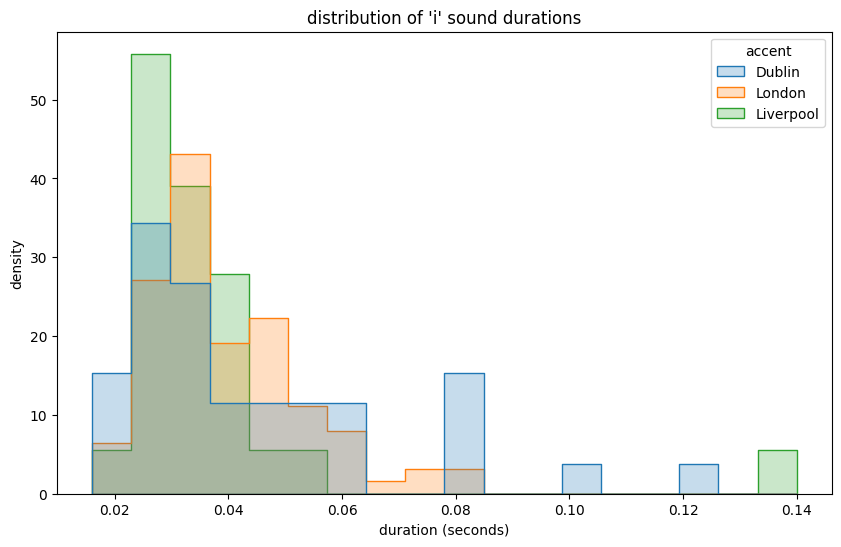

/tmp/ipykernel_8055/4063332291.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=current_utterance_data, x='accent', y='duration', palette=["blue", "red", "yellow"])


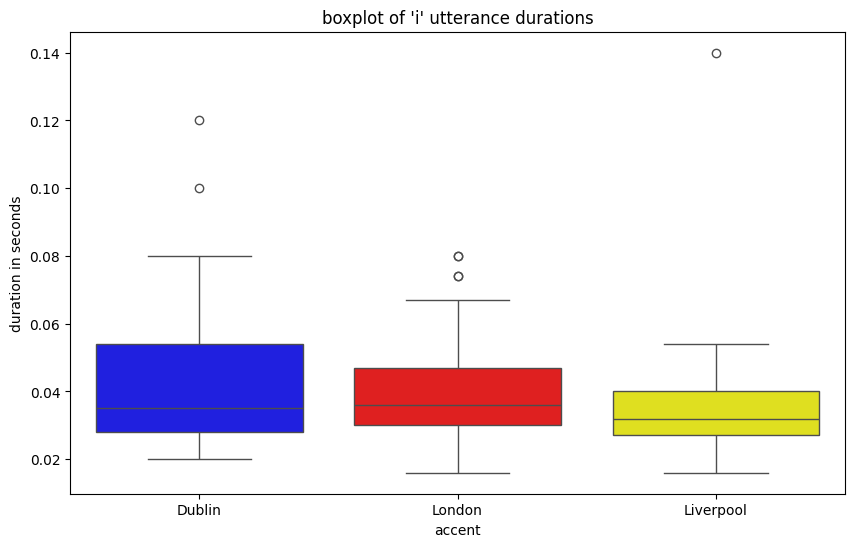

mann whitney U test between Dublin and London for utterance 'i': U=1759.5, Original p-value=0.8764808369002177, Permutation p-value=0.4311
mann whitney U test between Dublin and Liverpool for utterance 'i': U=606.0, Original p-value=0.12559659935511513, Permutation p-value=0.0641
mann whitney U test between London and Liverpool for utterance 'i': U=1515.5, Original p-value=0.028914021630666982, Permutation p-value=0.0142


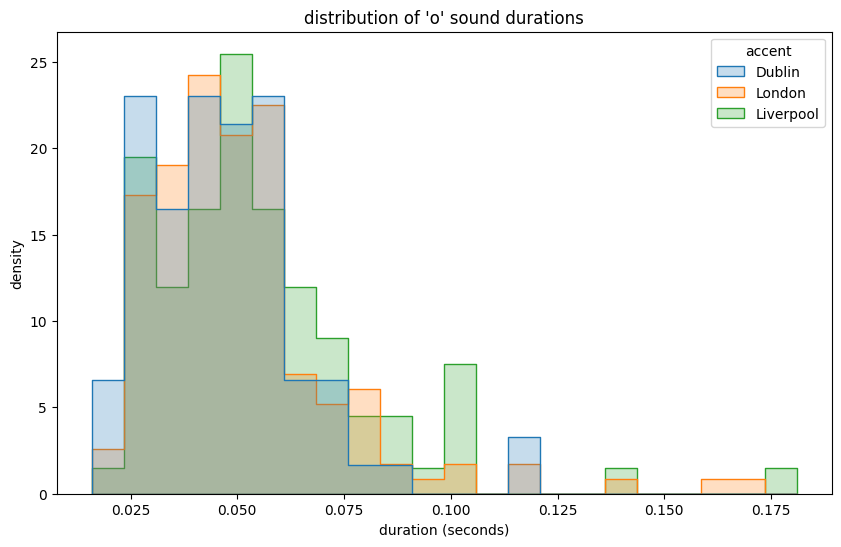

/tmp/ipykernel_8055/4063332291.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=current_utterance_data, x='accent', y='duration', palette=["blue", "red", "yellow"])


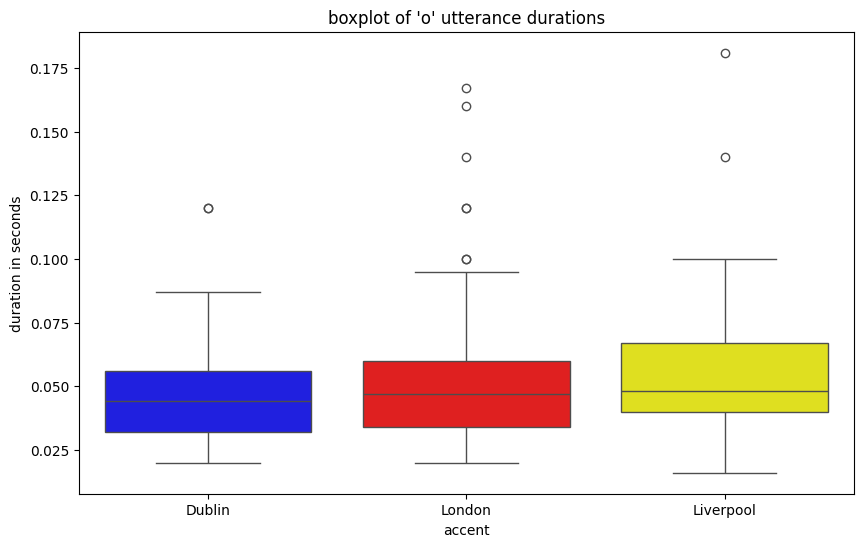

mann whitney U test between Dublin and London for utterance 'o': U=5575.5, Original p-value=0.1807132551006957, Permutation p-value=0.9084
mann whitney U test between Dublin and Liverpool for utterance 'o': U=2810.5, Original p-value=0.013109753035629348, Permutation p-value=0.9907
mann whitney U test between London and Liverpool for utterance 'o': U=6074.5, Original p-value=0.13971930371620211, Permutation p-value=0.93


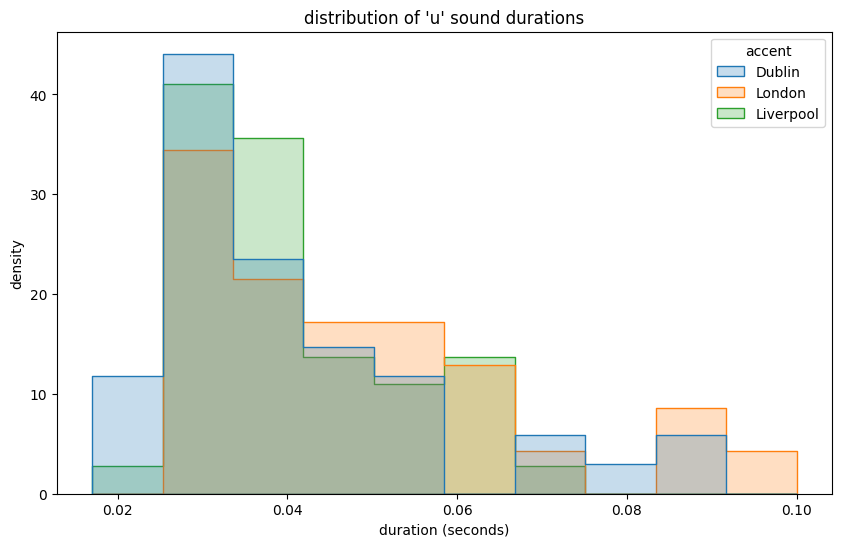

/tmp/ipykernel_8055/4063332291.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=current_utterance_data, x='accent', y='duration', palette=["blue", "red", "yellow"])


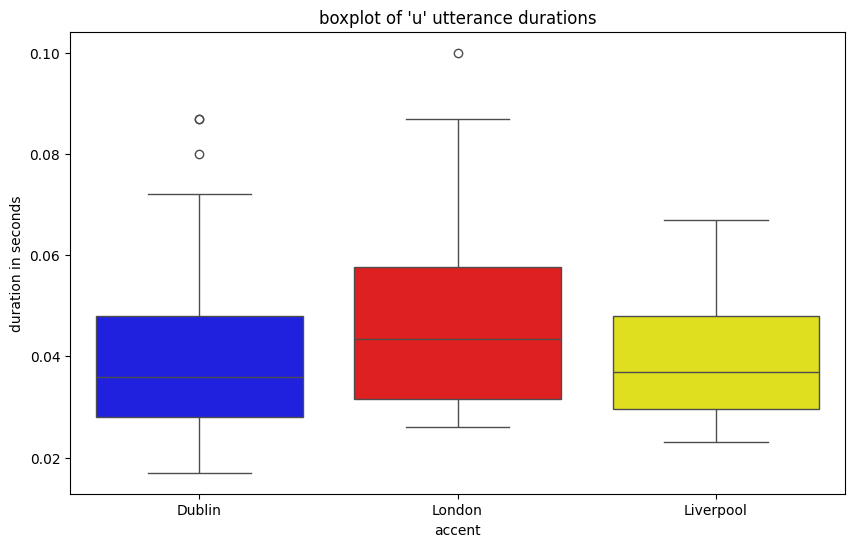

mann whitney U test between Dublin and London for utterance 'u': U=447.5, Original p-value=0.12318307286705338, Permutation p-value=0.9399
mann whitney U test between Dublin and Liverpool for utterance 'u': U=851.5, Original p-value=0.6594219144968678, Permutation p-value=0.663
mann whitney U test between London and Liverpool for utterance 'u': U=726.5, Original p-value=0.20285436230196296, Permutation p-value=0.1025


In [32]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from scipy import stats
import numpy as np
# if you are not running this script in a notebook environment, you may need to import
# perform_mann_whitney_and_permutation_test from the pitch script.

def calculate_durations(directory, accent, utterance):
    durations = []
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            audio_path = os.path.join(directory, filename)
            audio, sr = librosa.load(audio_path, sr=None)
            duration = librosa.get_duration(audio, sr=sr) - 4
            print(filename + " " + str(duration))
            durations.append({'accent': accent, 'duration': duration, 'utterance': utterance})
    return durations




def analyse_durations(dataframe, sounds, base_directories):
    for utterance in utterances:
        current_utterance_data = dataframe[dataframe['utterance'] == utterance]
        
        plt.figure(figsize=(10, 6))
        sns.histplot(data=current_utterance_data, x='duration', hue='accent', element='step', 
                     stat='density', common_norm=False)
        plt.title(f"distribution of '{utterance}' sound durations")
        plt.xlabel('duration (seconds)')
        plt.ylabel('density')
        plt.show()

        plt.figure(figsize=(10, 6))
        sns.boxplot(data=current_utterance_data, x='accent', y='duration', palette=["blue", "red", "yellow"])
        plt.title(f"boxplot of '{utterance}' utterance durations")
        plt.xlabel('accent')
        plt.ylabel('duration in seconds')
        plt.show()

        accents = list(base_directories.keys())
        for i in range(len(accents)):
            for x in range(i+1, len(accents)):
                data_1 = current_utterance_data[current_utterance_data['accent'] == accents[i]]['duration'].to_numpy()
                data_2 = current_utterance_data[current_utterance_data['accent'] == accents[x]]['duration'].to_numpy()
                original_stat, original_p_value, p_value_perm = perform_mann_whitney_and_permutation_test(data_1, 
                                                                                                          data_2)
                print(f"mann whitney U test between {accents[i]} and {accents[x]} for utterance '{utterance}': U={original_stat}, Original p-value={original_p_value}, Permutation p-value={p_value_perm}")

duration_data = pd.DataFrame()

for utterance in utterances:
    for accent, base_dir in base_directories.items():
        directory = os.path.join(base_dir, utterance)
        duration_data = pd.concat([duration_data, 
                                       pd.DataFrame(calculate_durations(directory, accent, utterance))])

analyse_durations(duration_data, utterances, base_directories)


<H2>Formant analysis<H2>

In [ ]:
import librosa
import numpy as np
import pandas as pd
import os
import random
import scipy.stats as stats
# if you are not running this script in a notebook environment, you may need to import
# perform_mann_whitney_and_permutation_test from the pitch script.

def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    return audio, sr

def trim_silence(audio, sr):
    '''
    A silence buffer was applied to improve the performance the NN model.
    This is a quick access function added to trim the buffer off when needed. 
    '''
    return audio[2*sr:-2*sr]

def get_formants(audio, sr):
    '''
    this code detects the top 3 freqency peaks which represents the formants.
    This code was guided by the work completed in:
    Rathee, A. (2020)
    and 
    rayryeng. (2020)
    and
    McFee et al. (2015) 
    '''
    magnitude_spec = np.abs(librosa.stft(audio))
    mean_spectrum = np.mean(magnitude_spec, axis=1)
    peaks = librosa.util.peak_pick(mean_spectrum, pre_max=3, 
                                   post_max=3, pre_avg=3, 
                                   post_avg=5, delta=0.5, wait=10)
    formants = sorted(peaks[:3])
    # convert formant frequencies (top 3 obtained in previous line of code, 
    # to the matching frequency values in hertz which is what is needed for the analysis
    formants_hz = librosa.core.fft_frequencies(sr=sr)[formants]
    return formants_hz if len(formants_hz) == 3 else [0, 0, 0]


def process_directory(directory):
    formant_data = []
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            audio, sr = load_audio(os.path.join(directory, filename))
            audio = trim_silence(audio, sr)
            formants = get_formants(audio, sr)
            formant_data.append([filename] + list(formants))
    return pd.DataFrame(formant_data, columns=['Filename', 'F1', 'F2', 'F3'])


# iterate through the utterances
for utterance in utterances:
    print(f"utternance: '{utterance}'")
    accent_data = {}


    for accent, base_dir in base_directories.items():
        directory = os.path.join(base_dir, utterance)
        data = process_directory(directory)
        accent_data[accent] = data

    # balance the data sets, this is only needed if the data is imbalanced, which it was for this proejct
    min_count = min(len(accent_data[accent]) for accent in accent_data)
    for accent in accent_data:
        if len(accent_data[accent]) > min_count:
            accent_data[accent] = accent_data[accent].sample(min_count, random_state=8)

        print(f"{accent} descriptive stats for utterance '{utterance}':")
        print(accent_data[accent].describe().drop('count'))
        print(" ")

    # get the mann whitney U test results and execute and 
    # execute a permutation test for each formant also
    print("mann whitney U and perm test results")
    for formant in ['F1', 'F2', 'F3']:
        for accent_1 in base_directories:
            for accent_2 in base_directories:
                if accent_1 < accent_2:  # there was an issue with duplication on the results
                    formant_data_1 = accent_data[accent_1][formant]
                    formant_data_2 = accent_data[accent_2][formant]
                    stat, p_value, p_value_perm = perform_mann_whitney_and_permutation_test(formant_data_1, 
                                                                                            formant_data_2)
                    # for each formant, print out the results so these can be copied into a table for report
                    print(f"{formant} between {accent_1} and {accent_2} for '{utterance}': U={stat}, p-value={p_value}, Permutation p-value={p_value_perm}")
    print(" ")


<H2>Intensity Analysis<H2>

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import random
import scipy.stats as stats
# if you are not running this script in a notebook environment, you may need to import
# perform_mann_whitney_and_permutation_test from the pitch script.

def calculate_mean_intensity(file_path):
    '''
    this function is responsible for calculating the average loudness of the passed in file path.
    the average loudness is commonly referred to as the audio intensity. Guidance for this function 
    was taken from:
    Harris et al. (2020)
    and 
    AJonas Adler (2022)
    '''
    y, sr = librosa.load(file_path, sr=None)
    absolute_intensity_val  = np.abs(y) #not sure if np (absolute or abs) function should be used here
    mean_intensity = np.mean(absolute_intensity_val)
    return mean_intensity

def process_directory(directory):
    intensities = []
    for file in os.listdir(directory):
        if file.endswith('.wav'):
            file_path = os.path.join(directory, file)
            intensity = calculate_mean_intensity(file_path)
            intensities.append((file, intensity))
    return intensities


for utterance in utterances:
    print(f"running for utterance: '{utterance}'")
    all_data = {}

    for accent, base_dir in base_directories.items():
        directory = os.path.join(base_dir, utterance)
        intensities = process_directory(directory)
        df = pd.DataFrame(intensities, columns=['filename', 'intensity'])
        all_data[accent] = df

    # balancing the data between the accents, have some discrepency in some cases
    min_count = min(len(all_data[accent]) for accent in all_data)
    for accent in all_data:
        if len(all_data[accent]) > min_count:
            all_data[accent] = all_data[accent].sample(n=min_count, random_state=8)
    
    # mann whitney U test resutls and permutation results for each set of accents
    print("mann whitney U and permutation results for utterance:", utterance)
    accents = list(all_data.keys())
    for i in range(len(accents)):
        for j in range(i+1, len(accents)):
            accent_1, accent_2 = accents[i], accents[j]
            data_1 = all_data[accent_1]['intensity']
            data_2 = all_data[accent_2]['intensity']
            stat, p_value, p_value_perm = perform_mann_whitney_and_permutation_test(data_1.values, data_2.values)
            print(f"between {accent_1} and {accent_2}: U={stat}, p-value={p_value}, permutation p-value={p_value_perm}")
    print(" ")


<H2>Constanant Analysis<H2>

In [62]:
import os
import librosa
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import scipy.stats as stats
# if you are not running this script in a notebook environment, you may need to import
# perform_mann_whitney_and_permutation_test from the pitch script.


def get_energy_features(file_path):
    '''
    Return the count of peaks and average energy of these peaks.
    This code was guided by work completed in:
    iranroman (2018) and Plotly Technologies Inc (2015)
    '''
    y, sr = librosa.load(file_path, sr=16000)

    # remove the 2 seconds from the start and end of the audio that I added to improve performance on segmentation
    if len(y) > 4 * sr: 
        y_trimmed = y[2*sr:-2*sr]  # cut the 2 seconds from start and end
    else:
        y_trimmed = y

    frame_length = 64
    hop_length = 256
    energy = np.array([sum(abs(y_trimmed[i:i+frame_length]**2)) for i in range(0, len(y_trimmed), hop_length)])
    peaks, _ = find_peaks(energy, height=np.mean(energy))
    num_peaks = len(peaks)
    mean_energy = np.mean(energy[peaks]) if peaks.size > 0 else 0
    return {"num_peaks": num_peaks, "mean_energy": mean_energy}


def analyse_directory(directory):
    # iterate over the directory containing wav files and process each one
    data = []
    for file_name in os.listdir(directory):
        if file_name.endswith('.wav'):
            file_path = os.path.join(directory, file_name)
            features = get_energy_features(file_path)
            data.append(features)
    return pd.DataFrame(data)

# changing the utterance list and base directories since the focus is now on constonants
utterances = ['d', 't']
base_directories = {
    'Dublin': '/home/garrett/Workspace/msc/speech_seg/dublin/features/Constant_Quality/',
    'Liverpool':'/home/garrett/Workspace/msc/speech_seg/liverpool/features/Constant_Quality/',
    'London': '/home/garrett/Workspace/msc/speech_seg/london/features/Constant_Quality/',
}

# this is the dataframe that will keep all the feature data
accent_features_df = pd.DataFrame()

# iterate through the utterances and process each one
for utterance in utterances:
    for accent, base_dir in base_directories.items():
        directory = os.path.join(base_dir, utterance, utterance) 
        df = analyse_directory(directory)
        df['Group'] = accent
        df['Utterance'] = utterance
        accent_features_df = pd.concat([accent_features_df, df])

# run all various tests, these include:
# shapiro wilk 
# levene test 
# mann whitney u and permutation test
for utterance in utterances:
    print(" ")
    print(f"statistical test on utterance: '{utterance}'")
    for feature in ['num_peaks', 'mean_energy']:
        print(" ")
        print(f"feature: {feature}")
        #shapiro testing
        for accent in base_directories.keys():
            data = accent_features_df[(accent_features_df['Group'] == accent) & 
                                      (accent_features_df['Utterance'] == utterance)][feature]
            _, p_value_shapiro = stats.shapiro(data)
            print(f"{accent} shapiro wilk p-value on {feature}: {p_value_shapiro}")
        
        #levens testing
        data_groups = [accent_features_df[(accent_features_df['Group'] == accent) & 
                                          (accent_features_df['Utterance'] == utterance)][feature] for accent in base_directories]
        _, p_value_levene = stats.levene(*data_groups)
        print(f"levene test p-val for {feature}: {p_value_levene}")

        # mann whitney testsing
        accents = list(base_directories.keys())
        for i in range(len(accents)-1):
            for x in range(i+1, len(accents)):
                data_1 = accent_features_df[(accent_features_df['Group'] == accents[i]) & 
                                            (accent_features_df['Utterance'] == utterance)][feature]
                data_2 = accent_features_df[(accent_features_df['Group'] == accents[x]) & 
                                            (accent_features_df['Utterance'] == utterance)][feature]
                stat, p_value, p_value_perm = perform_mann_whitney_and_permutation_test(data_1, data_2)
                print(f"mann whitney u and permutation test between accents {accents[i]} and {accents[x]} for {feature}: U={stat}, p-value={p_value}, Permutation p-value={p_value_perm}")

                
                

 
statistical test on utterance: 'd'
 
feature: num_peaks
Dublin shapiro wilk p-value on num_peaks: 3.182999003259468e-12
Liverpool shapiro wilk p-value on num_peaks: 2.853414932720705e-13
London shapiro wilk p-value on num_peaks: 1.698136076200285e-09
levene test p-val for num_peaks: 0.3268821875112331
mann whitney u and permutation test between accents Dublin and Liverpool for num_peaks: U=1680.0, p-value=0.34575416217594224, Permutation p-value=0.2396
mann whitney u and permutation test between accents Dublin and London for num_peaks: U=1100.0, p-value=0.6431189539620306, Permutation p-value=0.7422
mann whitney u and permutation test between accents Liverpool and London for num_peaks: U=1020.0, p-value=0.1845017250126998, Permutation p-value=0.9376
 
feature: mean_energy
Dublin shapiro wilk p-value on mean_energy: 2.174352718546397e-14
Liverpool shapiro wilk p-value on mean_energy: 1.0154469834975678e-14
London shapiro wilk p-value on mean_energy: 8.4078100384688e-12
levene test p-v

<H2>Spectral Feature Analysis on Constonants<H2>

In [ ]:
import librosa
import numpy as np
import os
import pandas as pd
import scipy.stats as stats
# if you are not running this script in a notebook environment, you may need to import
# perform_mann_whitney_and_permutation_test from the pitch script.

def get_spectral_feature_data(file_path):
    '''
    this function is responsible for getting the spectral centroid, bandwidth
    , flatness and rolloff. It follows methodology demonstrated in notebook found in :
    imsparsh. (2015)
    and 
    McFee et al. (2015) 
    '''
    y, sr = librosa.load(file_path, sr=None)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_flatness = librosa.feature.spectral_flatness(y=y)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    return np.mean(spectral_centroid), np.mean(spectral_bandwidth), np.mean(spectral_flatness), np.mean(spectral_rolloff)

def process_directory(directory):
    features = []
    for file_name in os.listdir(directory):
        if file_name.endswith('.wav'):
            file_path = os.path.join(directory, file_name)
            features.append(get_spectral_feature_data(file_path))
    return features


# this dataframe will hold all the accent feature data for analysis
accent_features_df = pd.DataFrame()

# iterate through utterances and get spectral features for each utterance in
# the base directory
for utterance in utterances:
    for accent, base_dir in base_directories.items():
        directory = os.path.join(base_dir, utterance, utterance) 
        features = process_directory(directory)
        df = pd.DataFrame(features, columns=['spectral centroid', 'spectral bandwidth', 
                                             'spectral flatness', 'spectral roll-off'])
        df['Accent'] = accent
        df['Utterance'] = utterance
        accent_features_df = pd.concat([accent_features_df, df])

# stats output and mann whitney u and permutation testing
for utterance in utterances:
    print(" ")
    print(f"stats output for utterance: '{utterance}'")
    for feature in ['spectral centroid', 'spectral bandwidth', 'spectral flatness', 'spectral roll-off']:
        print(" ")
        print(f"processing feature: {feature}")
        accents = accent_features_df['Accent'].unique()
        for i in range(len(accents) - 1):
            for x in range(i + 1, len(accents)):
                accent_1 = accents[i]
                accent_2 = accents[x]
                accent_feature_data_1 = accent_features_df[(accent_features_df['Accent'] == accent_1) & 
                                         (accent_features_df['Utterance'] == utterance)][feature]
                accent_feature_data_2 = accent_features_df[(accent_features_df['Accent'] == accent_2) & 
                                         (accent_features_df['Utterance'] == utterance)][feature]
                stat, p_value, p_value_perm = perform_mann_whitney_and_permutation_test(
                    accent_feature_data_1, accent_feature_data_2)
                print(f"mann whitney u and perm test on {accent_1} and {accent_2} with feature -{feature}: U={stat}, p-value={p_value}, Permutation p-value={p_value_perm}")


<H2>Cluster Analysis<H2>

In [ ]:
import librosa
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, adjusted_rand_score
import seaborn as sns

def mean_pitch(y, sr):
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch = []
    for t in range(pitches.shape[1]):
        index = magnitudes[:, t].argmax()
        if magnitudes[index, t] > 0:
            pitch.append(pitches[index, t])

    if len(pitch) == 0:
        return 0 

    return np.mean(pitch)

def detect_sound_duration(file_path):
    y, sr = librosa.load(file_path, sr=None)
    hop_length = 512
    frame_length = 1024
    energy = np.array([
        sum(abs(y[i:i+frame_length]**2))
        for i in range(0, len(y), hop_length)
    ])
    
    normalised_energy = energy / np.max(energy)
    threshold = 0.01
    onset_frames = np.where(normalised_energy > threshold)[0]
    
    if len(onset_frames) == 0:
        return 0
    
    onset_time = librosa.frames_to_time(onset_frames[0], sr=sr, hop_length=hop_length)
    offset_time = librosa.frames_to_time(onset_frames[-1], sr=sr, hop_length=hop_length)
    
    return offset_time - onset_time

def calculate_mean_intensity(y):
    return np.mean(np.abs(y))

def trim_silence(audio, sr):
    return audio[2*sr:-2*sr] 


def analyse_directory(directory):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            file_path = os.path.join(directory, filename)
            y, sr = librosa.load(file_path)
            audio_trimmed = trim_silence(y, sr)
            pitch = mean_pitch(y, sr)
            duration = detect_sound_duration(file_path)
            intensity = calculate_mean_intensity(y)
            formants = get_formants(audio_trimmed, sr)
            data.append([filename, pitch, duration, intensity] + list(formants))
    
    columns = ['Filename', 'Pitch', 'Duration', 'Intensity', 'F1', 'F2', 'F3']
    df = pd.DataFrame(data, columns=columns)
    return df

# back to using vowel utterances
vowels = ['a', 'i', 'o', 'u']
base_directories = {
    'Dublin': '/home/garrett/Workspace/msc/speech_seg/dublin/features/Monophthongs/',
    'Liverpool': '/home/garrett/Workspace/msc/speech_seg/liverpool/features/Monophthongs/',
}
group_to_label = {'Dublin': 0, 'Liverpool': 1}


for vowel in vowels:
    combined_df = pd.DataFrame()
    for city, base_dir in base_directories.items():
        directory = os.path.join(base_dir, vowel)
        df = analyse_directory(directory)
        df['Group'] = city
        df['Vowel'] = vowel
        combined_df = pd.concat([combined_df, df], ignore_index=True)
    
    # balance the dataset since there is some imbalancing between the 2 groups
    min_count = combined_df['Group'].value_counts().min()
    balanced_df = pd.DataFrame()
    for city in base_directories.keys():
        city_df = combined_df[combined_df['Group'] == city]
        balanced_df = pd.concat([balanced_df, city_df.sample(n=min_count, random_state=42)], ignore_index=True)
    
    balanced_df['TrueLabel'] = balanced_df['Group'].map(group_to_label)
    
    # features to use for the clustering model
    features = ['Pitch', 'Duration', 'Intensity', 'F1']
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(balanced_df[features])
    
    # K-means clustering
    kmeans = KMeans(n_clusters=2, random_state=0)
    kmeans.fit(scaled_features)
    balanced_df['Cluster'] = kmeans.labels_
    
    # PCA for visualization - There is no real benefit to using this other than educational
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(scaled_features)
    plt.figure(figsize=(10, 6))
    for i in range(kmeans.n_clusters):
        plt.scatter(principalComponents[balanced_df['Cluster'] == i, 0], principalComponents[balanced_df['Cluster'] == i, 1], label=f'Cluster {i}')
    plt.legend()
    plt.title(f'PCA Cluster Visualization for Vowel: {vowel}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()
    
    # create conf matrix and include the scores in outout
    cm = confusion_matrix(balanced_df['TrueLabel'], balanced_df['Cluster'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=group_to_label.keys(), yticklabels=group_to_label.keys())
    plt.title(f'confusion matrix on vowel: {vowel}')
    plt.ylabel('true label')
    plt.xlabel('cluster label')
    plt.show()
    
    # show performance scoring
    accuracy = accuracy_score(balanced_df['TrueLabel'], balanced_df['Cluster'])
    precision = precision_score(balanced_df['TrueLabel'], balanced_df['Cluster'], zero_division=0)
    recall = recall_score(balanced_df['TrueLabel'], balanced_df['Cluster'], zero_division=0)
    f1 = f1_score(balanced_df['TrueLabel'], balanced_df['Cluster'], zero_division=0)
    ari = adjusted_rand_score(balanced_df['TrueLabel'], balanced_df['Cluster'])
    print(f"vowel: {vowel}, accuracy: {accuracy}, precision: {precision}, recall: {recall}, F1 score: {f1}, adjusted rand index: {ari}")
    print("-" * 50)
